Epoch 1/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.8980 - loss: 0.2815 - val_accuracy: 0.9289 - val_loss: 0.2236
Epoch 2/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.9367 - loss: 0.1715 - val_accuracy: 0.9353 - val_loss: 0.1649
Epoch 3/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.9524 - loss: 0.1347 - val_accuracy: 0.9064 - val_loss: 0.3420
Epoch 4/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.9585 - loss: 0.1113 - val_accuracy: 0.9718 - val_loss: 0.0827
Epoch 5/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.9665 - loss: 0.0927 - val_accuracy: 0.9760 - val_loss: 0.0700
Epoch 6/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9677 - loss: 0.0889 - val_accuracy: 0.9486 - val_loss: 0.2027
Epoch 7/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9702 - loss: 0.0816 - val_accuracy: 0.9437 - val_loss: 0.1603
Epoch 8/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.9735 - loss: 0.0757 - 

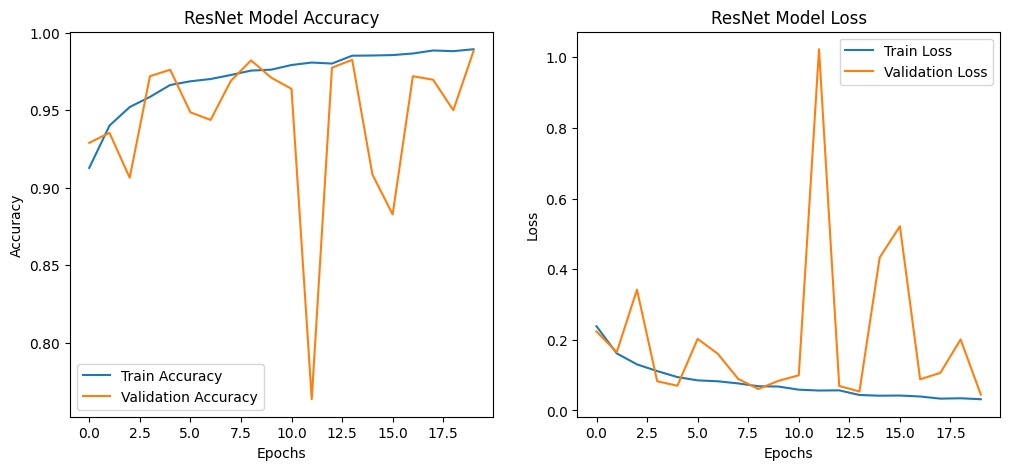

166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


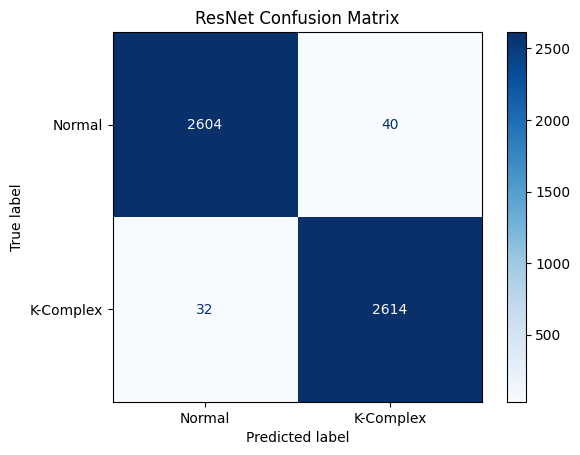

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.99      2644
   K-Complex       0.98      0.99      0.99      2646

    accuracy                           0.99      5290
   macro avg       0.99      0.99      0.99      5290
weighted avg       0.99      0.99      0.99      5290



In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# === Step 1: Load and preprocess the data ===
def load_data(folder_path):
    # Collect all Excel file paths in the folder
    file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.xlsx')]
    
    # Initialize empty lists to store features and labels
    X_list, y_list = [], []

    # Load and combine data from all files
    for file_path in file_paths:
        data = pd.read_excel(file_path)
        X_list.append(data.iloc[:, :-1].values)  # All columns except the last
        y_list.append(data.iloc[:, -1].values)  # The last column

    # Concatenate data from all files
    X = np.vstack(X_list)
    y = np.hstack(y_list)
    return X, y

# Provide the folder path containing the dataset
folder_path = 'D:/OneDrive_2024-12-27/Segmented by seperating spindles/Balanced_segmented/'  # Update this with your folder path
X, y = load_data(folder_path)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data for CNN (add a channel dimension)
X_scaled_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled_reshaped, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Convert labels to categorical format
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

# === Step 2: Define the ResNet architecture ===
def residual_block(input_tensor, filters, kernel_size=3, stride=1):
    x = Conv1D(filters, kernel_size, strides=stride, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Skip connection
    shortcut = Conv1D(filters, kernel_size=1, strides=stride, padding='same')(input_tensor)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_resnet(input_shape):
    inputs = Input(shape=input_shape)
    
    # Initial Conv layer
    x = Conv1D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)
    
    # Residual blocks
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=256)
    
    # Global Average Pooling and Dense layers
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)  # Binary classification
    
    model = Model(inputs, outputs)
    return model

# Build the ResNet model
resnet_model = build_resnet((X_scaled_reshaped.shape[1], 1))

# Compile the model
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === Step 3: Train the ResNet model ===
history_resnet = resnet_model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=20,  # Adjust as needed
    batch_size=32,
    verbose=1
)

# === Step 4: Evaluate the ResNet model ===
test_loss_resnet, test_accuracy_resnet = resnet_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"ResNet Test Loss: {test_loss_resnet:.4f}")
print(f"ResNet Test Accuracy: {test_accuracy_resnet:.4f}")

# === Step 5: Plotting performance ===
import matplotlib.pyplot as plt

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.title('ResNet Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# === Step 6: Confusion Matrix and Classification Report ===
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Predict the classes for the test set
y_pred = resnet_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'K-Complex'])
disp.plot(cmap='Blues')
plt.title("ResNet Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(y_test, y_pred_classes, target_names=['Normal', 'K-Complex'])
print("Classification Report:")
print(report)
